In [585]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
os.getcwd()
from json import load

# MirrorRL

In [586]:
def plot(path, limsup = None):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    for f in all_folders:
        data = pd.read_csv(path+f+"/progress.csv")
        fig = plt.figure(0)
        if limsup != None:
            data = data[data["time_total_s"]<limsup]
        labels = f.split(",")
        eta = labels[1][4:]
        # "time_total_s" "average_reward" "q_error_train" "kl" "entropy"
        plt.plot(data["time_total_s"], data["average_reward"], label=eta)
    plt.legend()
    plt.show()

def plot_all(path, limsup = None, figsize=(10,8), single_pmts = False, time = False):

    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    for f in all_folders:
        df = pd.read_csv(path+f+"/progress.csv")
        with open(path+f+"/params.json") as fpms:
            pms = load(fpms)
            lab = "eta = " + str(pms["eta"])[:4]+ ", " + "# neurons = " + str(pms["nb_add_neurone_per_iter"])
        
        if limsup != None:
            df = df[df.index<limsup]

        if time:
            xfit = df["time_total_s"]
        else:
            xfit = df.index * pms["nb_samp_per_iter"]
        if not single_pmts or pms[single_pmts[0]] == single_pmts[1]:
            axs[0, 0].plot(xfit , df["average_reward"], label=lab)
            axs[0, 0].set_title("Rewards")
            axs[1, 0].plot(xfit , df["q_error_train"], label=lab)
            axs[1, 0].set_title("Loss")
            axs[1, 0].set_yscale('log')
            axs[0, 1].plot(xfit , df["kl"], label=lab)
            axs[0, 1].set_title("KL")
            axs[0, 1].set_yscale('log')
            axs[1, 1].plot(xfit , df["entropy"], label=lab)
            axs[1, 1].set_title("Entropy")
        plt.legend()
    fig.tight_layout()

In [587]:
def plot_all_av_std(path, limsup = None, time = False):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    df = pd.DataFrame()
    for f in all_folders:
        _df = pd.read_csv(path+f+"/progress.csv")
        with open(path+f+"/params.json") as fpms:
            pms = load(fpms)
        if limsup != None:
            _df = _df[_df["iterations_since_restore"]<limsup]
        _df["eta"] = pms["eta"]
        _df["nb_add_neurone_per_iter"] = pms["nb_add_neurone_per_iter"]
        _df["nb_samp_per_iter"] = pms["nb_samp_per_iter"]
        df = pd.concat([df, _df], ignore_index=True)

    df = df[["nb_samp_per_iter", "nb_add_neurone_per_iter", "eta", 'average_reward', 'q_error_train', "kl", "entropy", "experiment_id", "time_total_s", "time_since_restore", "iterations_since_restore"]]								  
    df = df.pivot_table(index= "iterations_since_restore", aggfunc=[np.mean,  np.std])
    
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    if time:
        xfit = df["mean"]["time_total_s"]
    else:
        xfit = df.index * df["mean"]["nb_samp_per_iter"]
    
    yfit = df["mean"]["average_reward"]
    dyfit = df["std"]["average_reward"]
    axs[0, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[0, 0].plot(xfit, yfit, color='orange', alpha=0.7)
    axs[0, 0].set_title("Reward")
    
    yfit = df["mean"]["q_error_train"]
    dyfit = df["std"]["q_error_train"]
    axs[1, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[1, 0].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 0].set_title("Loss")
    axs[1, 0].set_yscale('log')

    
    # xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["kl"]
    dyfit = df["std"]["kl"]
    axs[0, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[0, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[0, 1].set_title("KL") 
    axs[0, 1].set_yscale('log')

    # xfit = df["mean"]["time_total_s"]
    yfit = df["mean"]["entropy"]
    dyfit = df["std"]["entropy"]
    axs[1, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, color='blue', alpha=0.4)
    axs[1, 1].plot(xfit, yfit, color='orange', alpha=0.6)
    axs[1, 1].set_title("Entropy")

    fig.tight_layout()
    # return df


### Search good parameters for Cartpole 
Find best $\eta$

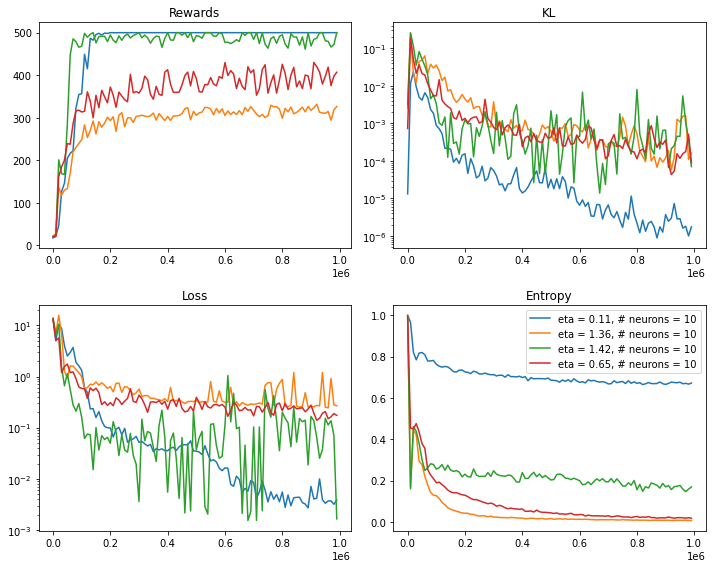

In [588]:
path = "ray_results/run_2022-05-16_15-43-05/"
plot_all(path, limsup=100) 
plt.savefig("./Figures/find_eta_cartpole__"+path.replace("/","_")+"_.png")

Plot average/std across seeds, $\eta=0.1$

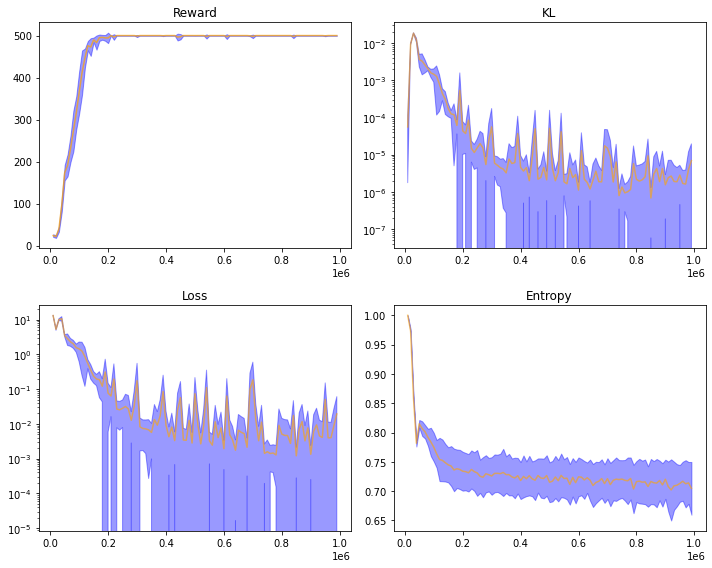

In [589]:
path = "ray_results/run_2022-05-19_14-13-03/"
plot_all_av_std(path,100)
plt.savefig("./Figures/CaRL_eta0.1_cartpole__"+path.replace("/","_")+"_.png")


### Search good parameters for Acrobot 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


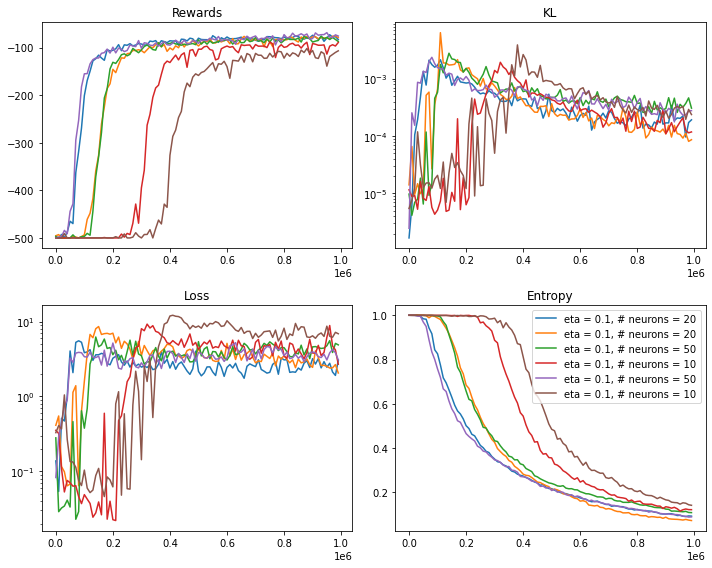

In [590]:
path = "ray_results/run_2022-05-21_12-25-09/"
plot_all(path,figsize=(10,8), single_pmts=["eta", 0.1]) 
plt.savefig("./Figures/find_eta-neurons_acrobot__"+path.replace("/","_")+"_.png")


In [601]:
def plot_all_av_std_by_pmts(path, limsup = None, time = False):
    all_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    df = pd.DataFrame()

    for f in all_folders:
        _df = pd.read_csv(path+f+"/progress.csv")
        with open(path+f+"/params.json") as fpms:
            pms = load(fpms)
        if limsup != None:
            _df = _df[_df["time_total_s"]<limsup]
        _df["eta"] = pms["eta"]
        _df["nb_add_neurone_per_iter"] = pms["nb_add_neurone_per_iter"]
        _df["nb_samp_per_iter"] = pms["nb_samp_per_iter"]
        df = pd.concat([df, _df], ignore_index=True)
    
    df = df[["nb_add_neurone_per_iter", "nb_samp_per_iter", "eta", 'average_reward', 'q_error_train', "kl", "entropy", "experiment_id", "time_total_s", "time_since_restore", "training_iteration"]]								  

    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    for nb in df["nb_add_neurone_per_iter"].unique():
        df_sub = df[df["nb_add_neurone_per_iter"]==nb]
        df_sub = df_sub.pivot_table(index= "training_iteration", aggfunc=[np.mean,  np.std])
        lab = "eta = " + str(pms["eta"])[:4]+ ", " + "# neurons = " + str(nb)

        
        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index * df_sub["mean"]["nb_samp_per_iter"]
        yfit = df_sub["mean"]["average_reward"]
        dyfit = df_sub["std"]["average_reward"]
        axs[0, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[0, 0].plot(xfit, yfit, alpha=0.7, label=lab)
        axs[0, 0].set_title("Reward")
        
        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index * df_sub["mean"]["nb_samp_per_iter"]
        yfit = df_sub["mean"]["q_error_train"]
        dyfit = df_sub["std"]["q_error_train"]
        axs[1, 0].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[1, 0].plot(xfit, yfit, alpha=0.6, label=lab)
        axs[1, 0].set_title("Loss")
        axs[1, 0].set_yscale('log')

        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index * df_sub["mean"]["nb_samp_per_iter"]
        yfit = df_sub["mean"]["kl"]
        dyfit = df_sub["std"]["kl"]
        axs[0, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[0, 1].plot(xfit, yfit, alpha=0.6, label=lab)
        axs[0, 1].set_title("KL") 
        axs[0, 1].set_yscale('log')


        if time:
            xfit = df_sub["mean"]["time_total_s"]
        else:
            xfit = df_sub.index * df_sub["mean"]["nb_samp_per_iter"]
        yfit = df_sub["mean"]["entropy"]
        dyfit = df_sub["std"]["entropy"]
        axs[1, 1].fill_between(xfit, yfit + dyfit, yfit-dyfit, alpha=0.4)
        axs[1, 1].plot(xfit, yfit, alpha=0.6, label=lab)
        axs[1, 1].set_title("Entropy")

        fig.tight_layout()
        plt.legend()

        

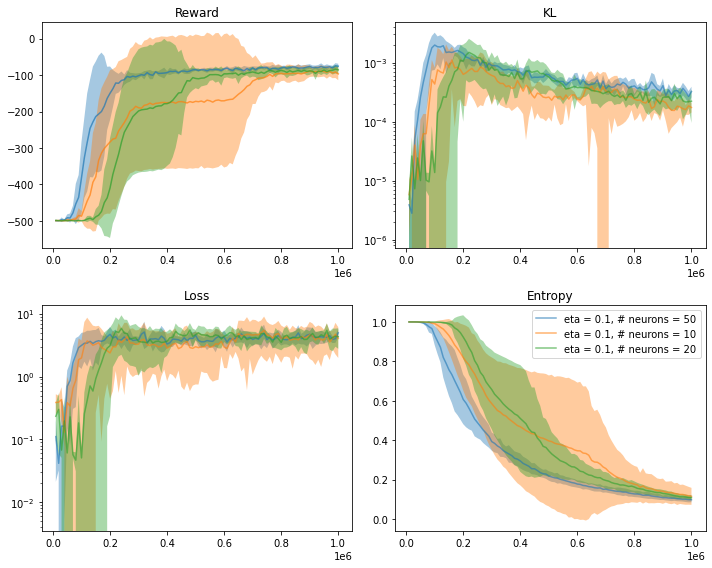

In [602]:
path = "ray_results/run_2022-05-22_21-51-02/"
plot_all_av_std_by_pmts(path, limsup = None, time = False)
plt.savefig("./Figures/CaRL_acrobot__"+path.replace("/","_")+".png")

# A2C

In [593]:
def plot_reward(path, time= False):
    df = pd.read_csv(path+"/data.csv")
    df = df[df["tag"]=="eval_rewards"]
    df = df.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
    if time:
        xfit = df["mean"]["dw_time_elapsed"]["eval_rewards"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["eval_rewards"]
    dyfit = df["std"]["value"]["eval_rewards"]
    plt.fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
    plt.plot(xfit, yfit, color='orange', alpha=0.7)
    plt.title("Reward")

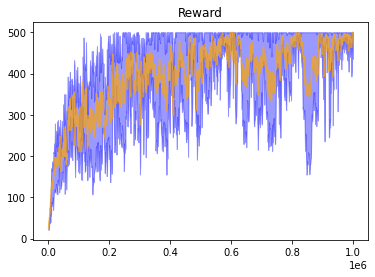

In [594]:
path = "results/solving_cartpole/a2c_cartpole/21/manager_data"
plot_reward(path)
plt.savefig("./Figures/a2c_cartpole_reward_"+path.replace("/","_")+".png")


In [595]:
def plot_rlberry_exp(path, time = False):
    df = pd.read_csv(path + "/data.csv")
    df = df[(df["tag"]=="eval_rewards") | (df["tag"]=="loss") | (df["tag"]=="kl") | (df["tag"]=="ent")]
    df = df.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["eval_rewards"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["eval_rewards"]
    dyfit = df["std"]["value"]["eval_rewards"]
    axs[0, 0].fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
    axs[0, 0].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[0, 0].set_title("eval_rewards")

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["loss"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["loss"]
    dyfit = df["std"]["value"]["loss"]
    axs[1, 0].fill_between(xfit, yfit - dyfit, yfit+dyfit, color='blue', alpha=0.4)
    axs[1, 0].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[1, 0].set_title("loss")

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["kl"]
    else:
        xfit = df.index  
    yfit = df["mean"]["value"]["kl"]
    dyfit = df["std"]["value"]["kl"]
    axs[0, 1].fill_between(xfit, np.maximum(yfit - dyfit,0), yfit+dyfit, color='blue', alpha=0.4)
    axs[0, 1].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[0, 1].set_title("kl") 

    if time:
       xfit = df["mean"]["dw_time_elapsed"]["ent"]
    else:
        xfit = df.index   
    yfit = df["mean"]["value"]["ent"]
    dyfit = df["std"]["value"]["ent"]
    axs[1, 1].fill_between(xfit, np.maximum(yfit - dyfit,0), yfit+dyfit, color='blue', alpha=0.4)
    axs[1, 1].plot(xfit, yfit, color='orange', alpha=0.4)
    axs[1, 1].set_title("ent")

    fig.tight_layout()

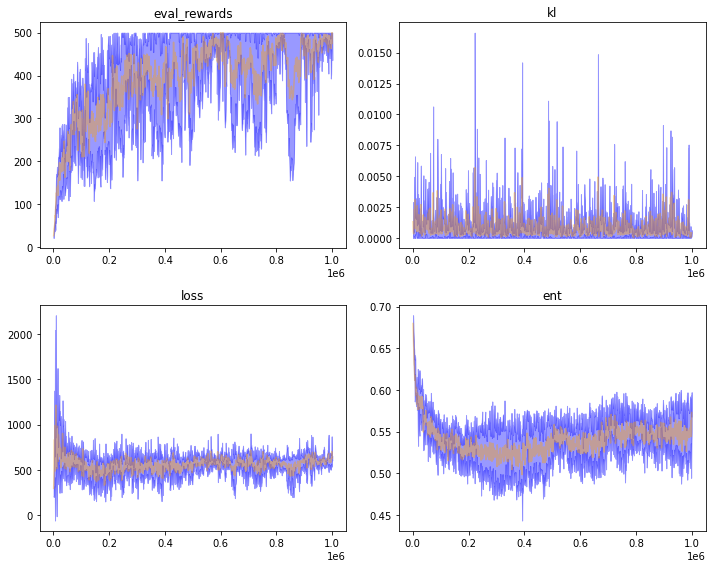

In [596]:
path = "results/solving_cartpole/a2c_cartpole/22/manager_data"
plot_rlberry_exp(path)
plt.savefig("./Figures/a2c_cartpole_"+path.replace("/","_")+".png")


### DQN

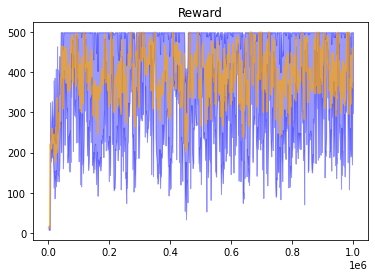

In [597]:
path = "results/solving_cartpole/dqn_cartpole/1/manager_data"
plot_reward(path)
plt.savefig("./Figures/dqn_cartpole_reward_"+path.replace("/","_")+".png")


In [598]:
def plot_rlberry_exp_dqn(path, time=False):

    df = pd.read_csv(path+"/data.csv")
    dfr = df[(df["tag"]=="eval_rewards")]
    dfr = dfr.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])
    fig, (ax1,ax2) = plt.subplots(1, 2,  figsize=(10,4))

    if time:
        xfit = dfr["mean"]["dw_time_elapsed"]["eval_rewards"]
    else:
        xfit  = dfr.index
    yfit = dfr["mean"]["value"]["eval_rewards"]
    dyfit = dfr["std"]["value"]["eval_rewards"]
    ax1.fill_between(xfit, yfit - dyfit, np.minimum(yfit+dyfit,500), color='blue', alpha=0.4)
    ax1.plot(xfit, yfit, color='orange', alpha=0.6)
    ax1.set_title("Reward")


    dfl = df[(df["tag"]=="losses/q_loss")]
    dfl = dfl.pivot_table(index= "global_step", columns="tag", aggfunc=[np.mean,  np.std])

    if time:
        xfit = dfl["mean"]["dw_time_elapsed"]["losses/q_loss"]
    else:
        xfit = dfl.index
    yfit = dfl["mean"]["value"]["losses/q_loss"]
    dyfit = dfl["std"]["value"]["losses/q_loss"]
    ax2.fill_between(xfit, np.maximum(0,yfit - dyfit), yfit+dyfit, color='blue', alpha=0.4)
    ax2.plot(xfit, yfit, color='orange', alpha=0.4)
    ax2.set_title("Loss")

    fig.tight_layout()


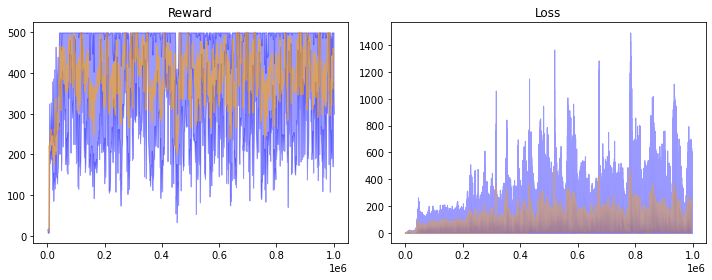

In [599]:
path = "results/solving_cartpole/dqn_cartpole/1/manager_data"
plot_rlberry_exp_dqn(path)
plt.savefig("./Figures/dqn_cartpole_"+path.replace("/","_")+".png")


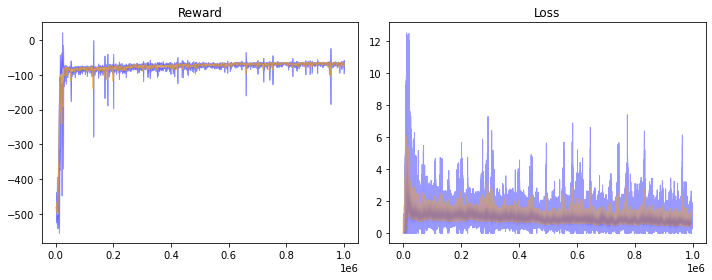

In [600]:
path = "results/solving_acrobot/dqn_acrobot/1/manager_data"
plot_rlberry_exp_dqn(path)
plt.savefig("./Figures/dqn_acrobot_"+path.replace("/","_")+".png")
